a script to preprocess and prepare the IDEAL dataset (hourly values) for training a transformer neural network. the data is household level timestamp, gas and electricity demand data, which is in a separate file for each household. I want to make a single csv file with timestamp, household id, gas, and electricity data. I want to pad missing data with NaN, and for the gas and electricity data to be aligned by timestamp and household id. 

'//Users//eoghan/Library//CloudStorage//OneDrive-UniversityCollegeLondon//Data//IDEAL//auxiliarydata//hourly_readings//'

In [1]:
import pandas as pd
import os
import gzip
import re


In [4]:

def load_and_unzip_files(path_to_data):
    files = os.listdir(path_to_data)
    dataframes = []  # list to store dataframes

    for file in files[0:3]:
        if file.endswith('_gas.csv.gz'):
            household_id = re.search('home(\d+)_', file).group(1)
            print(f'Loading data for household {household_id}...')  # f-string for formatting
            with gzip.open(os.path.join(path_to_data, file)) as f:  # use os.path.join for file paths
                df = pd.read_csv(f, header=None, names=['datetime', 'gas_pulse'])
                df['household_id'] = household_id
                dataframes.append(df)  # append df to list

    all_data = pd.concat(dataframes)  # concatenate all dataframes at once
    return all_data

In [5]:
def load_and_unzip_files(path_to_data):
    files = os.listdir(path_to_data)
    gas_dataframes = []  # list to store dataframes
    electric_dataframes = []

    counter = 0
    for file in files:
        # if counter > 10:
        #     break
        if file.endswith('_gas.csv.gz'):
            counter += 1
            household_id = re.search('home(\d+)_', file).group(1)
            # print(f'Loading gas data for household {household_id}...')  # f-string for formatting
            with gzip.open(os.path.join(path_to_data, file)) as f:  # use os.path.join for file paths
                df = pd.read_csv(f, header=None, names=['datetime', 'gas_pulse'])
                df['gas_pulse'] = pd.to_numeric(df['gas_pulse'], errors='coerce')  # convert to numeric
                df['datetime'] = pd.to_datetime(df['datetime'])  # convert to datetime if not already
                df = df.set_index('datetime').resample('H').mean()  # resample to hourly data
                df['household_id'] = household_id
                gas_dataframes.append(df)  # append df to list
        if file.endswith('_electric-combined.csv.gz'):
            counter += 1
            household_id = re.search('home(\d+)_', file).group(1)
            # print(f'Loading electric data for household {household_id}...')  # f-string for formatting
            with gzip.open(os.path.join(path_to_data, file)) as f:  # use os.path.join for file paths
                df = pd.read_csv(f, header=None, names=['datetime', 'electric_combined'])
                df['electric_combined'] = pd.to_numeric(df['electric_combined'], errors='coerce')  # convert to numeric
                df['datetime'] = pd.to_datetime(df['datetime'])  # convert to datetime if not already
                df = df.set_index('datetime').resample('H').mean()  # resample to hourly data
                df['household_id'] = household_id
                electric_dataframes.append(df)  # append df to list


    all_gas_data = pd.concat(gas_dataframes)  # concatenate all dataframes at once
    all_electric_data = pd.concat(electric_dataframes)  # concatenate all dataframes at once

    # Merge the two dataframes on 'datetime' and 'household_id'
    all_data = pd.merge(all_gas_data.reset_index(), all_electric_data.reset_index(), on=['datetime', 'household_id'], how='outer')[['datetime', 'household_id', 'gas_pulse', 'electric_combined']].sort_values(by=['household_id', 'datetime'])

    return all_data


In [6]:
path_to_data = '//Users//eoghan/Library//CloudStorage//OneDrive-UniversityCollegeLondon//Data//IDEAL//auxiliarydata//hourly_readings//'
all_data = load_and_unzip_files(path_to_data)

/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_95322/2077572922.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('datetime').resample('H').mean()  # resample to hourly data
/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_95322/2077572922.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('datetime').resample('H').mean()  # resample to hourly data
/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_95322/2077572922.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('datetime').resample('H').mean()  # resample to hourly data
/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_95322/2077572922.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('datetime').resa

In [7]:
len(all_data), len(all_data.household_id.unique())

(1714759, 255)

<Axes: title={'center': 'Average gas pulse per household'}, ylabel='Frequency'>

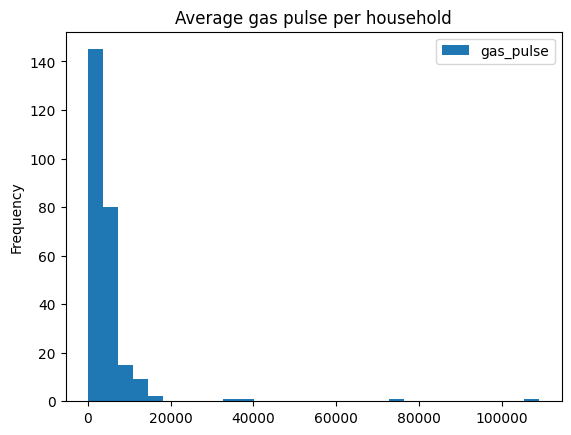

In [8]:
all_data.groupby(by='household_id')[['gas_pulse']].mean().plot(kind='hist',bins=30, title='Average gas pulse per household')

<Axes: title={'center': 'Average electric-combined per household'}, ylabel='Frequency'>

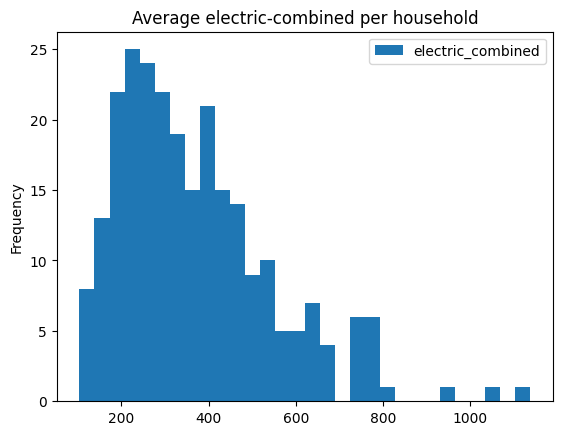

In [32]:
all_data.groupby(by='household_id')[['electric_combined']].mean().plot(kind='hist',bins=30, title='Average electric-combined per household')

<Axes: title={'center': 'Average gas pulse vs. average electric combined per household'}, xlabel='gas_pulse', ylabel='electric_combined'>

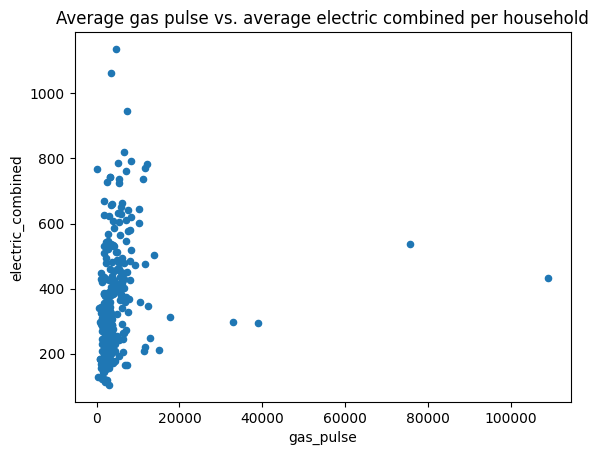

In [33]:
# now create a scatter plot showing the relationship between grouped gas_pulse and electric_combined
grouped = all_data.groupby(by='household_id')[['gas_pulse','electric_combined']].mean()
grouped.plot(kind='scatter', x='gas_pulse', y='electric_combined', title='Average gas pulse vs. average electric combined per household')

<Axes: title={'center': 'Average hourly gas pulse and electric combined for all households'}, xlabel='hour'>

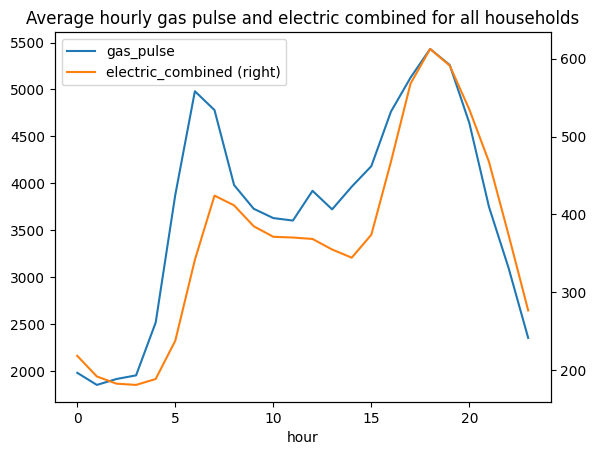

In [35]:
# now plot average hourly gas_pulse and electric_combined for all households, put the gas_pulse on the left y-axis and the electric_combined on the right y-axis
temp = all_data.copy()
temp['hour'] = temp['datetime'].dt.hour
grouped = temp.groupby(by='hour')[['gas_pulse','electric_combined']].mean()
grouped.plot(secondary_y='electric_combined', title='Average hourly gas pulse and electric combined for all households')

In [36]:
# save all_data to /Users/eoghan/repos/makemore/data
all_data.to_csv('/Users/eoghan/repos/makemore/data/all_data.csv', index=False)

In [37]:
# what are the earliest and latest datetimes in the dataset?
all_data['datetime'].min(), all_data['datetime'].max()

(Timestamp('2016-08-10 10:00:00'), Timestamp('2018-06-30 23:00:00'))

In [2]:
weather = pd.read_csv('/Users/eoghan/repos/makemore/data/forecast.csv',sep='\t',parse_dates=['dateforecastfor'])
weather.head()

,locationid,dateforecastfor,dateforecastmade,maxtemp,mintemp,tempunit,conditions,conditionsicon
0,Edinburgh,2016-08-10,2016-08-10,13,12,C,Rain,http://icons.wxug.com/i/c/k/rain.gif
1,Edinburgh,2016-08-11,2016-08-11,17,14,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif
2,Edinburgh,2016-08-12,2016-08-12,17,12,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif
3,Edinburgh,2016-08-13,2016-08-13,16,11,C,Mostly Cloudy,http://icons.wxug.com/i/c/k/mostlycloudy.gif
4,Edinburgh,2016-08-14,2016-08-14,17,9,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif


In [3]:
import holidays


weather['day_of_week'] = weather['dateforecastfor'].dt.dayofweek
weather['is_weekend'] = weather['day_of_week'].isin([5, 6])

# Create list of UK bank holidays
uk_holidays = holidays.UK(years=list(range(weather['dateforecastfor'].dt.year.min(), weather['dateforecastfor'].dt.year.max()+1)))

# Check if date is a UK bank holiday
weather['is_bank_holiday'] = weather['dateforecastfor'].isin(uk_holidays)
weather.head()

/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_95322/2669416681.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  weather['is_bank_holiday'] = weather['dateforecastfor'].isin(uk_holidays)


,locationid,dateforecastfor,dateforecastmade,maxtemp,mintemp,tempunit,conditions,conditionsicon,day_of_week,is_weekend,is_bank_holiday
0,Edinburgh,2016-08-10,2016-08-10,13,12,C,Rain,http://icons.wxug.com/i/c/k/rain.gif,2,False,False
1,Edinburgh,2016-08-11,2016-08-11,17,14,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif,3,False,False
2,Edinburgh,2016-08-12,2016-08-12,17,12,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif,4,False,False
3,Edinburgh,2016-08-13,2016-08-13,16,11,C,Mostly Cloudy,http://icons.wxug.com/i/c/k/mostlycloudy.gif,5,True,False
4,Edinburgh,2016-08-14,2016-08-14,17,9,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif,6,True,False


In [23]:
daily = all_data.groupby(by=['household_id', all_data['datetime'].dt.date])[['gas_pulse','electric_combined']].mean().reset_index() 
# rename gas_pulse and electric_combined columns to indicate they are means
daily = daily.rename(columns={'gas_pulse':'mean_gas_pulse','electric_combined':'mean_electric_combined'})
daily['datetime'] = pd.to_datetime(daily['datetime'])
daily.dtypes

household_id                      object
datetime                  datetime64[ns]
mean_gas_pulse                   float64
mean_electric_combined           float64
dtype: object

In [21]:
weather.dtypes

locationid                  object
dateforecastfor     datetime64[ns]
dateforecastmade            object
maxtemp                      int64
mintemp                      int64
tempunit                    object
conditions                  object
conditionsicon              object
day_of_week                  int32
is_weekend                    bool
is_bank_holiday               bool
dtype: object

In [24]:

# merge daily with weather on dateforecastfor, including maxtemp, mintemp, conditions, is_weekend, is_bank_holiday
merged = pd.merge(daily, weather.loc[weather['locationid'] == 'Edinburgh',:], left_on='datetime', right_on='dateforecastfor', how='left')
# drop dateforecastfor column
merged = merged.drop(columns='dateforecastfor')
merged.head()


,household_id,datetime,mean_gas_pulse,mean_electric_combined,locationid,dateforecastmade,maxtemp,mintemp,tempunit,conditions,conditionsicon,day_of_week,is_weekend,is_bank_holiday
0,100,2017-03-07,5277.200000,342.900000,Edinburgh,2017-03-07,10.0,4.0,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif,1.0,False,False
1,100,2017-03-08,6831.619048,252.666667,Edinburgh,2017-03-08,11.0,5.0,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif,2.0,False,False
2,100,2017-03-09,1282.588235,202.791667,Edinburgh,2017-03-09,11.0,3.0,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif,3.0,False,False
3,100,2017-03-10,4168.190476,222.333333,Edinburgh,2017-03-10,10.0,7.0,C,Overcast,http://icons.wxug.com/i/c/k/cloudy.gif,4.0,False,False
4,100,2017-03-11,1264.000000,243.083333,Edinburgh,2017-03-11,13.0,6.0,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif,5.0,True,False


In [26]:
# drop locationid, dateforcastmade, tempunit, conditionsicon
merged = merged.drop(columns=['locationid','dateforecastmade','tempunit','conditionsicon'])
merged.head()

,household_id,datetime,mean_gas_pulse,mean_electric_combined,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday
0,100,2017-03-07,5277.200000,342.900000,10.0,4.0,Chance of Rain,1.0,False,False
1,100,2017-03-08,6831.619048,252.666667,11.0,5.0,Chance of Rain,2.0,False,False
2,100,2017-03-09,1282.588235,202.791667,11.0,3.0,Chance of Rain,3.0,False,False
3,100,2017-03-10,4168.190476,222.333333,10.0,7.0,Overcast,4.0,False,False
4,100,2017-03-11,1264.000000,243.083333,13.0,6.0,Chance of Rain,5.0,True,False


In [29]:
# let's round the mean_gas_pulse and mean_electric_combined columns to 0 decimal places
merged['mean_rounded_gas_pulse'] = merged['mean_gas_pulse'].round(0)
merged['mean_rounded_electric_combined'] = merged['mean_electric_combined'].round(0)
merged = merged.drop(columns=['mean_gas_pulse','mean_electric_combined'])
merged.head()

,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0


In [30]:
# save data to /Users/eoghan/repos/makemore/data
merged.to_csv('/Users/eoghan/repos/makemore/data/daily_demand_and_weather.csv', index=False)